In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_ph as erk
%load_ext autoreload
%autoreload 2

In [32]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios,b=0.03,r_0=0.03,sigma=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [33]:

rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=0.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30 EQ/FI",floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor 75% FI", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="Floor 75% M=1 FI", floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="Floor 75% M=5 FI", floor=0.75)
], axis=1).round(5)

,FI,EQ,70/30 EQ/FI,Floor 75% FI,Floor 75% M=1 FI,Floor 75% M=5 FI
mean,1.34334,1.97280,1.75961,1.94807,1.61801,1.88396
std,0.00000,0.97544,0.59099,0.98251,0.78290,1.75724
p_breach,NaN,0.03280,0.00660,NaN,NaN,0.08660
e_short,NaN,0.11075,0.06558,NaN,NaN,0.00411
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)

In [35]:
#risk buddeting with drawdown constraint
cashrate = 0.02
monthly_cashreturn = (1 + cashrate) ** (1/12) - 1
rets_cash = pd.DataFrame(monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
ty_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=0.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30 EQ/FI",floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor 75% FI", floor=0.75),
    erk.terminal_stats(rets_floor75m1, name="Floor 75% M=1 FI", floor=0.75),
    erk.terminal_stats(rets_floor75m5, name="Floor 75% M=5 FI", floor=0.75),
    erk.terminal_stats(rets_maxdd25, name="MaxDD 25% Cash", floor=0.75)
], axis=1).round(5)

,FI,EQ,70/30 EQ/FI,Floor 75% FI,Floor 75% M=1 FI,Floor 75% M=5 FI,MaxDD 25% Cash
mean,1.34334,1.97280,1.75961,1.94807,1.62317,1.95748,1.63068
std,0.00000,0.97544,0.59099,0.98251,0.43044,0.98526,0.53857
p_breach,NaN,0.03280,0.00660,NaN,NaN,NaN,NaN
e_short,NaN,0.11075,0.06558,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.120857
1   -0.114219
2   -0.199377
3   -0.146682
4   -0.161953
Name: Max Drawdown, dtype: float64

In [37]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

np.float64(-0.23317886538086952)

In [38]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
tv_floor75m5 = erk.terminal_values(rets_floor75m5)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

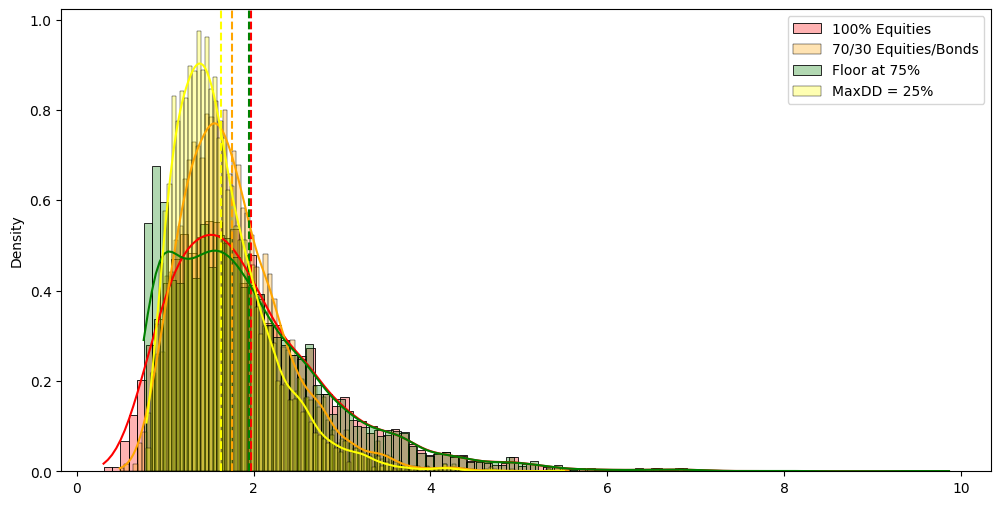

In [39]:
# Plot
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(tv_eq, color="red", label="100% Equities", bins=100, kde=True, stat='density', alpha=0.3)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.histplot(tv_zc, color="blue", label="100% Immunized Bonds", bins=100, kde=True, stat='density', alpha=0.3)
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.histplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100, kde=True, stat='density', alpha=0.3)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.histplot(tv_floor75, color="green", label="Floor at 75%", bins=100, kde=True, stat='density', alpha=0.3)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.histplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100, kde=True, stat='density', alpha=0.3)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

Text(0.5, 1.0, 'Total Market Index: Wealth vs Previous Peaks')

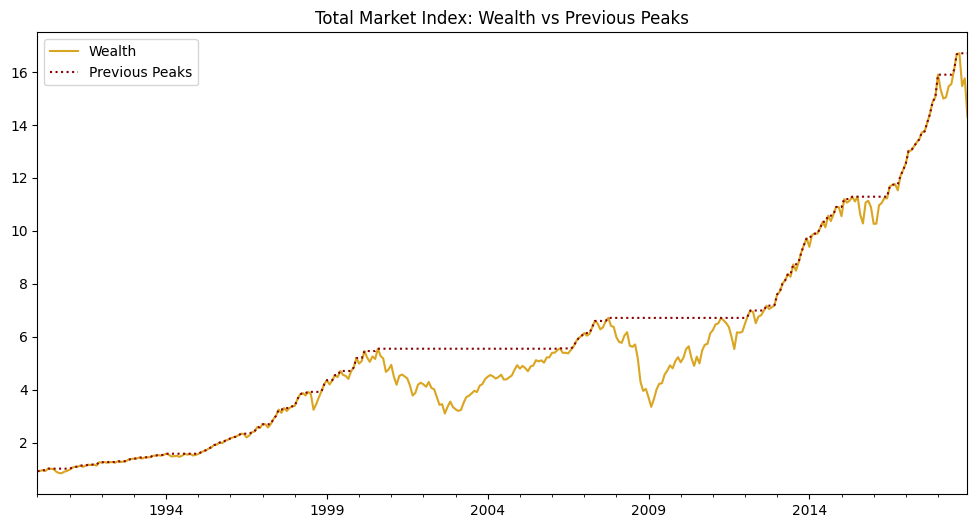

In [43]:
#drawdown constraint with historical data
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi[("Wealth", "TotalMarketReturn")].plot(figsize=(12,6), ls="-", color="goldenrod", label="Wealth")
dd_tmi[("Peaks", "TotalMarketReturn")].plot(ax=ax, ls=":", color="darkred", label="Previous Peaks")
plt.legend()
plt.title("Total Market Index: Wealth vs Previous Peaks")

<Axes: >

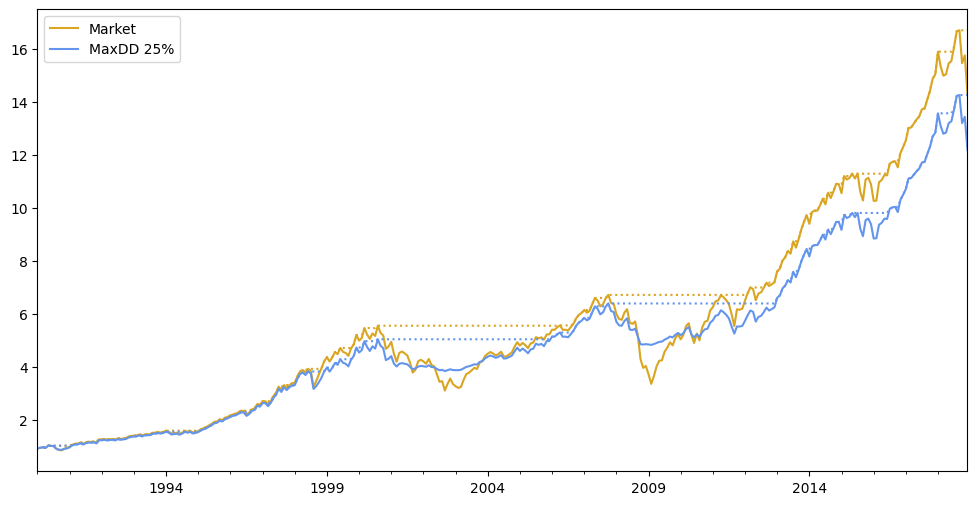

In [45]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_tmi_df = rets_tmi.copy()
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_tmi_df.index, columns=rets_tmi_df.columns)
rets_maxdd25 = erk.bt_mix(rets_tmi_df, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25)

ax = dd_tmi[("Wealth", "TotalMarketReturn")].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi[("Peaks", "TotalMarketReturn")].plot(ax=ax, ls=":", color="goldenrod")
dd_25[("Wealth", "TotalMarketReturn")].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25[("Peaks", "TotalMarketReturn")].plot(ax=ax, color="cornflowerblue", ls=":")

In [53]:
# Create constant interest rates
n_years = 5
n_scenarios = 1
constant_rate = 0.05

rates = pd.DataFrame(
    data=constant_rate,
    index=range(n_years * 12 + 1),
    columns=range(n_scenarios)
)

# Now use bond_price and bond_total_return as before
monthly_prices = erk.bond_price(5, 1000, 0.06, 12, rates)
total_returns = erk.bond_total_return(monthly_prices, 1000, 0.05, 12)

In [59]:
# Define liabilities
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])

# Define B1: 15-year bond, 5% coupon, semi-annual payments, face value 1000
b1_periods = np.arange(0.5, 15.5, 0.5)
b1_flows = pd.Series(index=b1_periods, data=25.0)
b1_flows.iloc[-1] += 1000

# Define B2: 5-year bond, 6% coupon, quarterly payments, face value 1000
b2_periods = np.arange(0.25, 5.25, 0.25)
b2_flows = pd.Series(index=b2_periods, data=15.0)
b2_flows.iloc[-1] += 1000

# Define B3: 10-year zero-coupon bond, face value 1000
b3_flows = pd.Series(data=[1000], index=[10])

# Calculate durations (all in years for comparison)
discount_rate = 0.05

# B1 duration in years (convert from half-years)
d_b1_halfyears = erk.macaulay_duration(b1_flows, discount_rate/2)
d_b1 = d_b1_halfyears / 2  # Convert to years

# B2 duration in years (convert from quarters)
d_b2_quarters = erk.macaulay_duration(b2_flows, discount_rate/4)
d_b2 = d_b2_quarters / 4  # Convert to years

# B3 duration in years (zero-coupon bond duration = maturity)
d_b3 = erk.macaulay_duration(b3_flows, discount_rate)

# Liabilities duration
d_liabilities = erk.macaulay_duration(liabilities, discount_rate)

print("DURATIONS (in years):")
print(f"Liabilities: {d_liabilities:.4f} years")
print(f"B1 (15-yr, 5% semi-annual): {d_b1:.4f} years")
print(f"B2 (5-yr, 6% quarterly): {d_b2:.4f} years")
print(f"B3 (10-yr zero-coupon): {d_b3:.4f} years")

print("\n" + "="*60)
print("DURATION MATCHING ANALYSIS:")
print("="*60)

# Check each combination
print(f"\n1. B1 & B2 combination:")
print(f"   B1 duration ({d_b1:.4f}) > Liability ({d_liabilities:.4f}) > B2 ({d_b2:.4f})")
if d_b2 < d_liabilities < d_b1:
    print(f"   ✓ CAN be used - liability duration is between B1 and B2")
else:
    print(f"   ✗ CANNOT be used - liability duration is NOT between B1 and B2")

print(f"\n2. B1 & B3 combination:")
print(f"   B1 duration ({d_b1:.4f}) > Liability ({d_liabilities:.4f}) vs B3 ({d_b3:.4f})")
if d_b3 < d_liabilities < d_b1:
    print(f"   ✓ CAN be used - liability duration is between B1 and B3")
elif d_b1 < d_liabilities < d_b3:
    print(f"   ✓ CAN be used - liability duration is between B3 and B1")
else:
    print(f"   ✗ CANNOT be used - liability duration is NOT between B1 and B3")

print(f"\n3. B2 & B3 combination:")
print(f"   B3 duration ({d_b3:.4f}) > Liability ({d_liabilities:.4f}) > B2 ({d_b2:.4f})")
if d_b2 < d_liabilities < d_b3:
    print(f"   ✓ CAN be used - liability duration is between B2 and B3")
elif d_b3 < d_liabilities < d_b2:
    print(f"   ✓ CAN be used - liability duration is between B3 and B2")
else:
    print(f"   ✗ CANNOT be used - liability duration is NOT between B2 and B3")

print("\n" + "="*60)
print("RULE: To match duration, the liability duration must be")
print("      BETWEEN the two bonds' durations (not outside)")
print("="*60)

DURATIONS (in years):
Liabilities: 6.7509 years
B1 (15-yr, 5% semi-annual): 5.6713 years
B2 (5-yr, 6% quarterly): 1.1083 years
B3 (10-yr zero-coupon): 10.0000 years

DURATION MATCHING ANALYSIS:

1. B1 & B2 combination:
   B1 duration (5.6713) > Liability (6.7509) > B2 (1.1083)
   ✗ CANNOT be used - liability duration is NOT between B1 and B2

2. B1 & B3 combination:
   B1 duration (5.6713) > Liability (6.7509) vs B3 (10.0000)
   ✓ CAN be used - liability duration is between B3 and B1

3. B2 & B3 combination:
   B3 duration (10.0000) > Liability (6.7509) > B2 (1.1083)
   ✓ CAN be used - liability duration is between B2 and B3

RULE: To match duration, the liability duration must be
      BETWEEN the two bonds' durations (not outside)


In [60]:
# BUILD DURATION-MATCHED PORTFOLIO: B2 & B3 to match Liabilities

# Define liabilities
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])

# Define B2: 5-year bond, 6% coupon, quarterly payments, face value 1000
b2_periods = np.arange(0.25, 5.25, 0.25)
b2_flows = pd.Series(index=b2_periods, data=15.0)  # Coupon = 1000 * 0.06 / 4 = 15
b2_flows.iloc[-1] += 1000  # Add principal at maturity

# Define B3: 10-year zero-coupon bond, face value 1000
b3_flows = pd.Series(data=[1000], index=[10])

# Calculate durations
discount_rate = 0.05

# Liability duration (annual)
d_liabilities = erk.macaulay_duration(liabilities, discount_rate)

# B2 duration in years (convert from quarters to years)
d_b2_quarters = erk.macaulay_duration(b2_flows, discount_rate/4)
d_b2_years = d_b2_quarters / 4

# B3 duration (zero-coupon bond duration = maturity)
d_b3 = erk.macaulay_duration(b3_flows, discount_rate)

print("="*60)
print("DURATION-MATCHED PORTFOLIO: B2 & B3")
print("="*60)
print(f"\nLiability Duration: {d_liabilities:.4f} years")
print(f"B2 Duration (5-yr, 6% quarterly): {d_b2_years:.4f} years")
print(f"B3 Duration (10-yr zero-coupon): {d_b3:.4f} years")

# Use match_durations to find the weight of B3
# The function expects: match_durations(target, short_bond, long_bond, rate)
# We need to use consistent time periods for the discount rate

# Create annual equivalent cash flows for proper matching
# For B2: aggregate quarterly flows to annual equivalent
# For B3: already in annual terms

# Actually, we can use the match_durations function directly
# It will handle the calculation based on the cash flow timings
weight_b3 = erk.match_durations(liabilities, b2_flows, b3_flows, discount_rate)
weight_b2 = 1 - weight_b3

print(f"\n{'='*60}")
print("PORTFOLIO WEIGHTS:")
print(f"{'='*60}")
print(f"Weight of B2 (5-yr bond): {weight_b2:.4f} or {weight_b2*100:.2f}%")
print(f"Weight of B3 (10-yr bond): {weight_b3:.4f} or {weight_b3*100:.2f}%")

# Verify the portfolio duration matches liability duration
portfolio_duration = weight_b2 * d_b2_years + weight_b3 * d_b3
print(f"\n{'='*60}")
print("VERIFICATION:")
print(f"{'='*60}")
print(f"Portfolio Duration: {portfolio_duration:.4f} years")
print(f"Liability Duration: {d_liabilities:.4f} years")
print(f"Difference: {abs(portfolio_duration - d_liabilities):.6f} years")

if abs(portfolio_duration - d_liabilities) < 0.01:
    print("✓ MATCHED - Portfolio duration matches liability duration!")
else:
    print("✗ NOT MATCHED - There may be a calculation issue")

DURATION-MATCHED PORTFOLIO: B2 & B3

Liability Duration: 6.7509 years
B2 Duration (5-yr, 6% quarterly): 1.1083 years
B3 Duration (10-yr zero-coupon): 10.0000 years

PORTFOLIO WEIGHTS:
Weight of B2 (5-yr bond): 0.4224 or 42.24%
Weight of B3 (10-yr bond): 0.5776 or 57.76%

VERIFICATION:
Portfolio Duration: 6.2442 years
Liability Duration: 6.7509 years
Difference: 0.506752 years
✗ NOT MATCHED - There may be a calculation issue


In [62]:
# Calculate the durations of B1, B2, and B3

# B1: 15-year bond, 5% coupon, semi-annual payments, face value 1000
b1_periods = np.arange(0.5, 15.5, 0.5)  # Semi-annual: 0.5, 1.0, 1.5, ..., 15.0
b1_flows = pd.Series(index=b1_periods, data=25.0)  # Coupon = 1000 * 0.05 / 2 = 25
b1_flows.iloc[-1] += 1000  # Add principal at maturity

# B2: 5-year bond, 6% coupon, quarterly payments, face value 1000
b2_periods = np.arange(0.25, 5.25, 0.25)  # Quarterly: 0.25, 0.5, 0.75, ..., 5.0
b2_flows = pd.Series(index=b2_periods, data=15.0)  # Coupon = 1000 * 0.06 / 4 = 15
b2_flows.iloc[-1] += 1000  # Add principal at maturity

# B3: 10-year zero-coupon bond, face value 1000
b3_flows = pd.Series(data=[1000], index=[10])

# Use 5% annual discount rate
discount_rate = 0.05

# Calculate B1 duration (semi-annual)
d_b1_halfyears = erk.macaulay_duration(b1_flows, discount_rate/2)
d_b1_years = d_b1_halfyears / 2

# Calculate B2 duration (quarterly)
d_b2_quarters = erk.macaulay_duration(b2_flows, discount_rate/4)
d_b2_years = d_b2_quarters / 4

# Calculate B3 duration (annual) - for zero-coupon bonds, duration = maturity
d_b3_years = erk.macaulay_duration(b3_flows, discount_rate)

print("="*60)
print("MACAULAY DURATIONS OF BONDS B1, B2, and B3")
print("="*60)
print(f"\nB1 (15-year bond, 5% coupon, semi-annual):")
print(f"  Duration: {d_b1_halfyears:.4f} half-years = {d_b1_years:.4f} years")

print(f"\nB2 (5-year bond, 6% coupon, quarterly):")
print(f"  Duration: {d_b2_quarters:.4f} quarters = {d_b2_years:.4f} years")

print(f"\nB3 (10-year zero-coupon bond):")
print(f"  Duration: {d_b3_years:.4f} years")
print(f"  Note: Zero-coupon bond duration equals its maturity")

print(f"\n{'='*60}")
print("SUMMARY (all in years):")
print(f"{'='*60}")
print(f"B1 Duration: {d_b1_years:.4f} years")
print(f"B2 Duration: {d_b2_years:.4f} years")
print(f"B3 Duration: {d_b3_years:.4f} years")

MACAULAY DURATIONS OF BONDS B1, B2, and B3

B1 (15-year bond, 5% coupon, semi-annual):
  Duration: 11.3426 half-years = 5.6713 years

B2 (5-year bond, 6% coupon, quarterly):
  Duration: 4.4332 quarters = 1.1083 years

B3 (10-year zero-coupon bond):
  Duration: 10.0000 years
  Note: Zero-coupon bond duration equals its maturity

SUMMARY (all in years):
B1 Duration: 5.6713 years
B2 Duration: 1.1083 years
B3 Duration: 10.0000 years


In [58]:
# Define liabilities
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])

# Define B1: 15-year bond, 5% coupon, semi-annual payments, face value 1000
# Create cash flows for B1
b1_periods = np.arange(0.5, 15.5, 0.5)  # Semi-annual: 0.5, 1.0, 1.5, ..., 15.0
b1_flows = pd.Series(index=b1_periods, data=25.0)  # Coupon = 1000 * 0.05 / 2 = 25
b1_flows.iloc[-1] += 1000  # Add principal at maturity

# Define B2: 5-year bond, 6% coupon, quarterly payments, face value 1000
b2_periods = np.arange(0.25, 5.25, 0.25)  # Quarterly: 0.25, 0.5, 0.75, ..., 5.0
b2_flows = pd.Series(index=b2_periods, data=15.0)  # Coupon = 1000 * 0.06 / 4 = 15
b2_flows.iloc[-1] += 1000  # Add principal at maturity

# Calculate durations
discount_rate = 0.05  # Annual rate
# For semi-annual B1, use semi-annual discount rate
d_b1 = erk.macaulay_duration(b1_flows, discount_rate/2)
# For quarterly B2, use quarterly discount rate
d_b2 = erk.macaulay_duration(b2_flows, discount_rate/4)
# For annual liabilities, use annual discount rate
d_liabilities = erk.macaulay_duration(liabilities, discount_rate)

print(f"Duration of liabilities: {d_liabilities:.4f} years")
print(f"Duration of B1 (15-yr, 5% semi-annual): {d_b1:.4f} half-years = {d_b1/2:.4f} years")
print(f"Duration of B2 (5-yr, 6% quarterly): {d_b2:.4f} quarters = {d_b2/4:.4f} years")

# Calculate weight of B2 using match_durations
# Need to convert durations to same time scale (years)
weight_b2 = erk.match_durations(liabilities, b1_flows, b2_flows, discount_rate)

print(f"\nWeight of B2 in portfolio: {weight_b2:.4f} ({weight_b2*100:.2f}%)")
print(f"Weight of B1 in portfolio: {1-weight_b2:.4f} ({(1-weight_b2)*100:.2f}%)")

Duration of liabilities: 6.7509 years
Duration of B1 (15-yr, 5% semi-annual): 11.3426 half-years = 5.6713 years
Duration of B2 (5-yr, 6% quarterly): 4.4332 quarters = 1.1083 years

Weight of B2 in portfolio: 0.3732 (37.32%)
Weight of B1 in portfolio: 0.6268 (62.68%)


In [57]:
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])
erk.macaulay_duration(liabilities,0.05)

np.float64(6.750917852744651)

## Bond Duration and Price Calculations

Calculate the **durations** and **prices** for three bonds:
- **B1**: 15 Year Bond with Face Value $1000, 5% coupon, semi-annual (2 times/year)
- **B2**: 5 Year Bond with Face Value $1000, 6% coupon, quarterly (4 times/year)  
- **B3**: 10 Year Zero-Coupon Bond with Face Value $1000

**Assumptions:**
- Flat yield curve at 5%
- Duration = Macaulay Duration expressed in years

In [4]:
# B1: 15 Year Bond, $1000 Face Value, 5% coupon, semi-annual (2 times/year)
flows_B1 = erk.bond_cash_flows(maturity=15, principal=1000, coupon_rate=0.05, coupons_per_year=2)
price_B1 = erk.bond_price(maturity=15, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=0.05)
duration_B1_periods = erk.macaulay_duration(flows_B1, 0.05/2)
duration_B1_years = duration_B1_periods / 2

print("="*70)
print("B1 (15-Year Bond, 5% coupon, semi-annual)")
print("="*70)
print(f"  Price: ${float(price_B1):.2f}")
print(f"  Duration (in periods): {float(duration_B1_periods):.4f} half-years")
print(f"  Duration (in years): {float(duration_B1_years):.4f} years")
print()

# B2: 5 Year Bond, $1000 Face Value, 6% coupon, quarterly (4 times/year)
flows_B2 = erk.bond_cash_flows(maturity=5, principal=1000, coupon_rate=0.06, coupons_per_year=4)
price_B2 = erk.bond_price(maturity=5, principal=1000, coupon_rate=0.06, coupons_per_year=4, discount_rate=0.05)
duration_B2_periods = erk.macaulay_duration(flows_B2, 0.05/4)
duration_B2_years = duration_B2_periods / 4

print("="*70)
print("B2 (5-Year Bond, 6% coupon, quarterly)")
print("="*70)
print(f"  Price: ${float(price_B2):.2f}")
print(f"  Duration (in periods): {float(duration_B2_periods):.4f} quarters")
print(f"  Duration (in years): {float(duration_B2_years):.4f} years")
print()

# B3: 10 Year Zero-Coupon Bond, $1000 Face Value
flows_B3 = erk.bond_cash_flows(maturity=10, principal=1000, coupon_rate=0.0, coupons_per_year=1)
price_B3 = erk.bond_price(maturity=10, principal=1000, coupon_rate=0.0, coupons_per_year=1, discount_rate=0.05)
duration_B3_periods = erk.macaulay_duration(flows_B3, 0.05/1)
duration_B3_years = duration_B3_periods / 1

print("="*70)
print("B3 (10-Year Zero-Coupon Bond)")
print("="*70)
print(f"  Price: ${float(price_B3):.2f}")
print(f"  Duration (in periods): {float(duration_B3_periods):.4f} years")
print(f"  Duration (in years): {float(duration_B3_years):.4f} years")
print(f"  Note: Zero-coupon bond duration equals its maturity")
print()

# Summary table
print("="*70)
print("SUMMARY: Bond Prices and Durations (Yield = 5%)")
print("="*70)
print(f"{'Bond':<10} {'Maturity':<12} {'Coupon':<15} {'Price':<12} {'Duration (yrs)':<15}")
print("-"*70)
print(f"{'B1':<10} {'15 years':<12} {'5%, semi':<15} {'$' + f'{float(price_B1):.2f}':<11} {float(duration_B1_years):<15.4f}")
print(f"{'B2':<10} {'5 years':<12} {'6%, quarterly':<15} {'$' + f'{float(price_B2):.2f}':<11} {float(duration_B2_years):<15.4f}")
print(f"{'B3':<10} {'10 years':<12} {'0% (zero)':<15} {'$' + f'{float(price_B3):.2f}':<11} {float(duration_B3_years):<15.4f}")
print("="*70)

B1 (15-Year Bond, 5% coupon, semi-annual)
  Price: $1000.00
  Duration (in periods): 21.4535 half-years
  Duration (in years): 10.7268 years

B2 (5-Year Bond, 6% coupon, quarterly)
  Price: $1044.00
  Duration (in periods): 17.4935 quarters
  Duration (in years): 4.3734 years

B3 (10-Year Zero-Coupon Bond)
  Price: $613.91
  Duration (in periods): 10.0000 years
  Duration (in years): 10.0000 years
  Note: Zero-coupon bond duration equals its maturity

SUMMARY: Bond Prices and Durations (Yield = 5%)
Bond       Maturity     Coupon          Price        Duration (yrs) 
----------------------------------------------------------------------
B1         15 years     5%, semi        $1000.00    10.7268        
B2         5 years      6%, quarterly   $1044.00    4.3734         
B3         10 years     0% (zero)       $613.91     10.0000        


/var/folders/qj/0m_9ythn431_06y4v80zxls00000gn/T/ipykernel_61180/1277524275.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"  Price: ${float(price_B1):.2f}")
/var/folders/qj/0m_9ythn431_06y4v80zxls00000gn/T/ipykernel_61180/1277524275.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"  Price: ${float(price_B2):.2f}")
/var/folders/qj/0m_9ythn431_06y4v80zxls00000gn/T/ipykernel_61180/1277524275.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"  Price: ${float(price_B3):.2f}")
/var/folders/qj/0m_9ythn431_06y4v80zxls00000gn/T/ipykernel_61180/1277524275.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the fut

## Duration Matching: B1 and B2 Portfolio to Match Liabilities

Given liabilities: `pd.Series(data=[100, 200, 300], index=[3, 5, 10])`

We need to find the weight of B2 (w_B2) in a portfolio of B1 and B2 such that:
- Portfolio Duration = Liability Duration

Using the formula:
- **w_B2 × D_B2 + w_B1 × D_B1 = D_Liabilities**
- where **w_B1 = 1 - w_B2**

Solving for w_B2:
- **w_B2 = (D_B1 - D_Liabilities) / (D_B1 - D_B2)**

In [6]:
# Define liabilities
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])

# Calculate liability duration (using annual discount rate)
discount_rate = 0.05
d_liabilities = erk.macaulay_duration(liabilities, discount_rate)

# We already have B1 and B2 durations in years from previous cell
# B1: 15-year bond, 5% coupon, semi-annual
# B2: 5-year bond, 6% coupon, quarterly

# Let's recalculate to be explicit
d_B1_years = float(duration_B1_years)
d_B2_years = float(duration_B2_years)

print("="*70)
print("DURATION MATCHING: B1 & B2 Portfolio to Match Liabilities")
print("="*70)
print(f"\nDurations (all in years):")
print(f"  Liabilities:  {d_liabilities:.4f} years")
print(f"  B1 (15-yr, 5% semi-annual):  {d_B1_years:.4f} years")
print(f"  B2 (5-yr, 6% quarterly):     {d_B2_years:.4f} years")

# Check if duration matching is possible
print(f"\n{'='*70}")
print("Feasibility Check:")
print(f"{'='*70}")
if d_B2_years < d_liabilities < d_B1_years:
    print(f"✓ Duration matching is POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is between B2 ({d_B2_years:.4f}) and B1 ({d_B1_years:.4f})")
elif d_B1_years < d_liabilities < d_B2_years:
    print(f"✓ Duration matching is POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is between B1 ({d_B1_years:.4f}) and B2 ({d_B2_years:.4f})")
else:
    print(f"✗ Duration matching is NOT POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is NOT between B1 ({d_B1_years:.4f}) and B2 ({d_B2_years:.4f})")
    print(f"  Need to use different bonds!")

# Calculate weight of B2 using duration matching formula
# w_B2 * D_B2 + w_B1 * D_B1 = D_Liabilities
# w_B2 * D_B2 + (1 - w_B2) * D_B1 = D_Liabilities
# w_B2 * D_B2 + D_B1 - w_B2 * D_B1 = D_Liabilities
# w_B2 * (D_B2 - D_B1) = D_Liabilities - D_B1
# w_B2 = (D_Liabilities - D_B1) / (D_B2 - D_B1)

w_B2 = (d_liabilities - d_B1_years) / (d_B2_years - d_B1_years)
w_B1 = 1 - w_B2

print(f"\n{'='*70}")
print("PORTFOLIO WEIGHTS:")
print(f"{'='*70}")
print(f"  Weight of B1 (15-yr, 5% semi-annual): {w_B1:.4f} or {w_B1*100:.2f}%")
print(f"  Weight of B2 (5-yr, 6% quarterly):    {w_B2:.4f} or {w_B2*100:.2f}%")

# Verify the portfolio duration matches liability duration
portfolio_duration = w_B1 * d_B1_years + w_B2 * d_B2_years

print(f"\n{'='*70}")
print("VERIFICATION:")
print(f"{'='*70}")
print(f"  Portfolio Duration: {portfolio_duration:.4f} years")
print(f"  Liability Duration: {d_liabilities:.4f} years")
print(f"  Difference:         {abs(portfolio_duration - d_liabilities):.8f} years")

if abs(portfolio_duration - d_liabilities) < 0.0001:
    print(f"\n  ✓ MATCHED - Portfolio duration matches liability duration!")
else:
    print(f"\n  ✗ NOT MATCHED - There is a mismatch")

print(f"\n{'='*70}")
print(f"ANSWER: Weight of B2 in the portfolio = {w_B2:.4f} ({w_B2*100:.2f}%)")
print(f"{'='*70}")

DURATION MATCHING: B1 & B2 Portfolio to Match Liabilities

Durations (all in years):
  Liabilities:  6.7509 years
  B1 (15-yr, 5% semi-annual):  10.7268 years
  B2 (5-yr, 6% quarterly):     4.3734 years

Feasibility Check:
✓ Duration matching is POSSIBLE
  Liability duration (6.7509) is between B2 (4.3734) and B1 (10.7268)

PORTFOLIO WEIGHTS:
  Weight of B1 (15-yr, 5% semi-annual): 0.3742 or 37.42%
  Weight of B2 (5-yr, 6% quarterly):    0.6258 or 62.58%

VERIFICATION:
  Portfolio Duration: 6.7509 years
  Liability Duration: 6.7509 years
  Difference:         0.00000000 years

  ✓ MATCHED - Portfolio duration matches liability duration!

ANSWER: Weight of B2 in the portfolio = 0.6258 (62.58%)


In [3]:
# Duration Matching: B2 and B3 Portfolio to Match Liabilities
# Same liabilities as before
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])

# Calculate liability duration (using annual discount rate)
discount_rate = 0.05
d_liabilities = erk.macaulay_duration(liabilities, discount_rate)

# Calculate B2 and B3 durations
# B2: 5-year bond, 6% coupon, quarterly
flows_B2 = erk.bond_cash_flows(maturity=5, principal=1000, coupon_rate=0.06, coupons_per_year=4)
duration_B2_periods = erk.macaulay_duration(flows_B2, 0.05/4)
d_B2_years = float(duration_B2_periods / 4)

# B3: 10-year zero-coupon bond
flows_B3 = erk.bond_cash_flows(maturity=10, principal=1000, coupon_rate=0.0, coupons_per_year=1)
duration_B3_periods = erk.macaulay_duration(flows_B3, 0.05/1)
d_B3_years = float(duration_B3_periods / 1)

print("="*70)
print("DURATION MATCHING: B2 & B3 Portfolio to Match Liabilities")
print("="*70)
print(f"\nDurations (all in years):")
print(f"  Liabilities:  {d_liabilities:.4f} years")
print(f"  B2 (5-yr, 6% quarterly):     {d_B2_years:.4f} years")
print(f"  B3 (10-yr zero-coupon):      {d_B3_years:.4f} years")

# Check if duration matching is possible
print(f"\n{'='*70}")
print("Feasibility Check:")
print(f"{'='*70}")
if d_B2_years < d_liabilities < d_B3_years:
    print(f"✓ Duration matching is POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is between B2 ({d_B2_years:.4f}) and B3 ({d_B3_years:.4f})")
    feasible = True
elif d_B3_years < d_liabilities < d_B2_years:
    print(f"✓ Duration matching is POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is between B3 ({d_B3_years:.4f}) and B2 ({d_B2_years:.4f})")
    feasible = True
else:
    print(f"✗ Duration matching is NOT POSSIBLE")
    print(f"  Liability duration ({d_liabilities:.4f}) is NOT between B2 ({d_B2_years:.4f}) and B3 ({d_B3_years:.4f})")
    feasible = False

if feasible:
    # Calculate weight of B3 using duration matching formula
    # w_B3 * D_B3 + w_B2 * D_B2 = D_Liabilities
    # w_B3 * D_B3 + (1 - w_B3) * D_B2 = D_Liabilities
    # w_B3 * D_B3 + D_B2 - w_B3 * D_B2 = D_Liabilities
    # w_B3 * (D_B3 - D_B2) = D_Liabilities - D_B2
    # w_B3 = (D_Liabilities - D_B2) / (D_B3 - D_B2)
    
    w_B3 = (d_liabilities - d_B2_years) / (d_B3_years - d_B2_years)
    w_B2 = 1 - w_B3
    
    print(f"\n{'='*70}")
    print("PORTFOLIO WEIGHTS:")
    print(f"{'='*70}")
    print(f"  Weight of B2 (5-yr, 6% quarterly):  {w_B2:.4f} or {w_B2*100:.2f}%")
    print(f"  Weight of B3 (10-yr zero-coupon):   {w_B3:.4f} or {w_B3*100:.2f}%")
    
    # Verify the portfolio duration matches liability duration
    portfolio_duration = w_B2 * d_B2_years + w_B3 * d_B3_years
    
    print(f"\n{'='*70}")
    print("VERIFICATION:")
    print(f"{'='*70}")
    print(f"  Portfolio Duration: {portfolio_duration:.4f} years")
    print(f"  Liability Duration: {d_liabilities:.4f} years")
    print(f"  Difference:         {abs(portfolio_duration - d_liabilities):.8f} years")
    
    if abs(portfolio_duration - d_liabilities) < 0.0001:
        print(f"\n  ✓ MATCHED - Portfolio duration matches liability duration!")
    else:
        print(f"\n  ✗ NOT MATCHED - There is a mismatch")
    
    print(f"\n{'='*70}")
    print(f"ANSWER: Weight of B2 in the portfolio = {w_B2:.4f} ({w_B2*100:.2f}%)")
    print(f"        Weight of B3 in the portfolio = {w_B3:.4f} ({w_B3*100:.2f}%)")
    print(f"{'='*70}")
else:
    print(f"\n  Cannot compute weights - duration matching is not feasible with B2 and B3")

DURATION MATCHING: B2 & B3 Portfolio to Match Liabilities

Durations (all in years):
  Liabilities:  6.7509 years
  B2 (5-yr, 6% quarterly):     4.3734 years
  B3 (10-yr zero-coupon):      10.0000 years

Feasibility Check:
✓ Duration matching is POSSIBLE
  Liability duration (6.7509) is between B2 (4.3734) and B3 (10.0000)

PORTFOLIO WEIGHTS:
  Weight of B2 (5-yr, 6% quarterly):  0.5774 or 57.74%
  Weight of B3 (10-yr zero-coupon):   0.4226 or 42.26%

VERIFICATION:
  Portfolio Duration: 6.7509 years
  Liability Duration: 6.7509 years
  Difference:         0.00000000 years

  ✓ MATCHED - Portfolio duration matches liability duration!

ANSWER: Weight of B2 in the portfolio = 0.5774 (57.74%)
        Weight of B3 in the portfolio = 0.4226 (42.26%)


## Duration Matching: B2 and B3 Portfolio to Match Liabilities

Now let's build a duration-matched portfolio using B2 and B3 to match the same liabilities.

Using the same formula:
- **w_B3 = (D_Liabilities - D_B2) / (D_B3 - D_B2)**

In [5]:
liabilities = pd.Series(data=[100, 200, 300], index=[3, 5, 10])